# Классификация: превышает ли значение SI значение 8

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import lightgbm as lgb      
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, Booster as LGBMBooster  # LGBMBooster если понадобится
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    make_scorer,
)

import optuna
from optuna.integration import LightGBMTunerCV

In [3]:
df_clean = pd.read_csv("df_cleaned.csv")
df_clean.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,2,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Смотрим размер дата сета
df_clean.shape

(980, 196)

In [5]:
IC50_COL  = "IC50, mM"
TARGET_COL = "SI_above_8"

# Формируем бинарную целевую переменную SI больше 8
si_above_8 = (df_clean['SI'] > 8).astype(int)
print(f"SI above 8: {si_above_8.value_counts()}")

df_clean[TARGET_COL] = si_above_8

SI above 8: SI
0    627
1    353
Name: count, dtype: int64


In [6]:
# Удаляем целевые переменные и не информативный признак 
X = df_clean.drop(['IC50, mM', 'SI', 'CC50, mM', 'Unnamed: 0', TARGET_COL], axis=1)
y = df_clean[TARGET_COL]

In [7]:
# автоматически отбираем признаки с важностью выше медианы, чтобы сократить размерность данных.
rf = RandomForestClassifier(n_estimators=80, random_state=42)
selector = SelectFromModel(rf, threshold="median")  
X_selected = selector.fit_transform(X, y)
X_selected.shape

(980, 96)

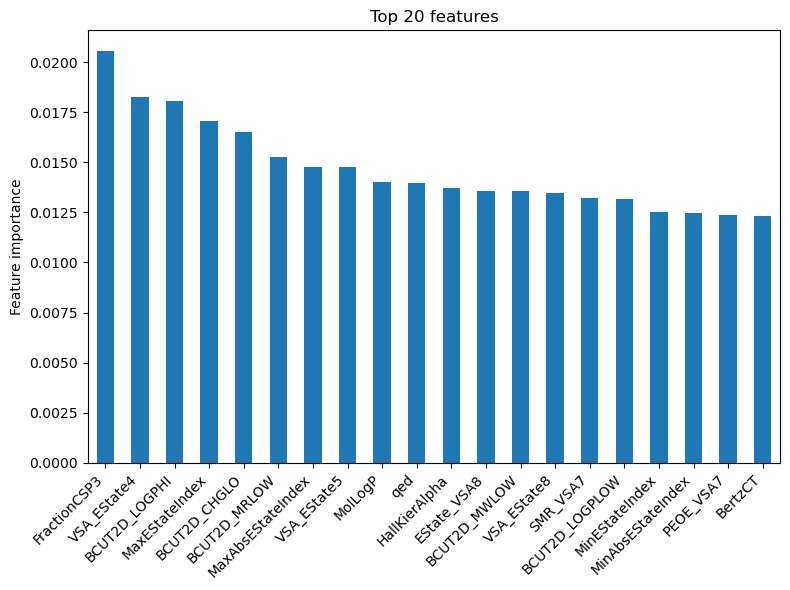

In [8]:
# названия и важности только для выбранных фич
mask            = selector.get_support()
selected_names  = X.columns[mask]
importances_sel = selector.estimator_.feature_importances_[mask]

# отсортируем и возьмём топ-20
feat_imp = (
    pd.Series(importances_sel, index=selected_names)
      .sort_values(ascending=False)
      .head(20)
)

# рисуем
plt.figure(figsize=(8, 6))
feat_imp.plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Top 20 features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

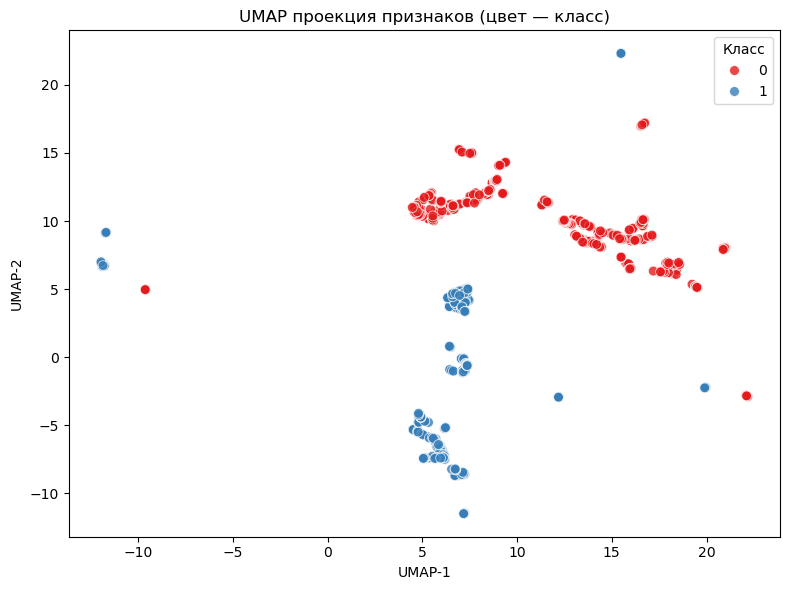

In [9]:
# Масштабирование
X_scaled = StandardScaler().fit_transform(X_selected)

# UMAP проекция в 2D
reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, metric="cosine")
X_umap = reducer.fit_transform(X_scaled, y)

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="Set1", s=50, alpha=0.8)
plt.title("UMAP проекция признаков (цвет — класс)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Класс")
plt.tight_layout()
plt.show()

In [10]:
# разделим данные на тренировачную и тестовую подвыбарку 
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [11]:
# Выводим распределение классов в обучающей выборке (в процентах)
class_dist = y_train.value_counts(normalize=True) * 100
print(f"\nРаспределение классов в обучающей выборке:\n"
      f"  IC50 > медианы: {class_dist[0]:.2f}%\n"
      f"  IC50 < медианы: {class_dist[1]:.2f}%")


Распределение классов в обучающей выборке:
  IC50 > медианы: 63.52%
  IC50 < медианы: 36.48%


In [12]:
# Список моделей для обучения
base_models_cls = {
    "RandomForest":  RandomForestClassifier(random_state=42, n_jobs=-1),
    "ExtraTrees":    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    "HistGBC":       HistGradientBoostingClassifier(random_state=42),
    "XGBoost":       XGBClassifier(random_state=42),
    "LightGBM":      LGBMClassifier(verbosity=-1, random_state=42),
    "CatBoost":      CatBoostClassifier(random_state=42, verbose=0),
}

# Оборачиваем каждую модель в Pipeline (scaler + модель)
models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models_cls.items()
}

# Кросс-валидация и метрики
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORERS = {
    "accuracy":  "accuracy",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1",
    "roc_auc":   "roc_auc"
}

results = {}

for name, pipe in models.items():
    print(f"Обучение {name}...")
    cv_res = cross_validate(
        pipe,
        X_train,           # уже готовый train-split
        y_train,
        cv=CV,
        scoring=SCORERS,
        n_jobs=-1,
        return_estimator=False
    )
    # усредняем метрики
    results[name] = {m: (cv_res[f'test_{m}'].mean(), cv_res[f'test_{m}'].std())
                     for m in SCORERS.keys()}
    print("  " + " | ".join(
        f"{m}: {mean:.3f}±{std:.3f}" for m, (mean, std) in results[name].items()
    ))

Обучение RandomForest...
  accuracy: 0.704±0.037 | precision: 0.621±0.068 | recall: 0.511±0.051 | f1: 0.557±0.043 | roc_auc: 0.729±0.040
Обучение ExtraTrees...
  accuracy: 0.696±0.033 | precision: 0.608±0.066 | recall: 0.504±0.042 | f1: 0.548±0.031 | roc_auc: 0.715±0.034
Обучение HistGBC...
  accuracy: 0.704±0.038 | precision: 0.611±0.059 | recall: 0.535±0.073 | f1: 0.568±0.055 | roc_auc: 0.727±0.042
Обучение XGBoost...
  accuracy: 0.691±0.052 | precision: 0.590±0.077 | recall: 0.525±0.074 | f1: 0.554±0.068 | roc_auc: 0.716±0.043
Обучение LightGBM...
  accuracy: 0.699±0.030 | precision: 0.611±0.057 | recall: 0.500±0.041 | f1: 0.548±0.034 | roc_auc: 0.726±0.029
Обучение CatBoost...
  accuracy: 0.718±0.042 | precision: 0.643±0.072 | recall: 0.528±0.062 | f1: 0.577±0.055 | roc_auc: 0.742±0.036


In [13]:
# Итоговая таблица mean ± std
summary = pd.DataFrame({
    (metric, stat): {
        model: results[model][metric][0] if stat == "mean" else results[model][metric][1]
        for model in results
    }
    for metric in SCORERS.keys()
    for stat in ["mean", "std"]
}).sort_values(("f1", "mean"), ascending=False)

print("\nСравнение моделей (CV, mean ± std):")
display(summary)


Сравнение моделей (CV, mean ± std):


accuracy           precision              recall            \
                  mean       std      mean       std      mean       std   
CatBoost      0.718039  0.042334  0.643323  0.071521  0.528131  0.062329   
HistGBC       0.704026  0.037980  0.611335  0.059433  0.535269  0.073385   
RandomForest  0.704018  0.036982  0.620811  0.067602  0.510647  0.051462   
XGBoost       0.691254  0.052026  0.590199  0.077051  0.524803  0.073792   
ExtraTrees    0.696374  0.033185  0.608469  0.065930  0.503630  0.041995   
LightGBM      0.698930  0.029716  0.611380  0.056563  0.500060  0.041491   

                    f1             roc_auc            
                  mean       std      mean       std  
CatBoost      0.577406  0.055426  0.741973  0.036275  
HistGBC       0.567695  0.054873  0.726540  0.041502  
RandomForest  0.557471  0.042719  0.729297  0.040107  
XGBoost       0.553563  0.068201  0.716006  0.043372  
ExtraTrees    0.548009  0.031348  0.714521  0.034013  
LightGBM      0.547998  0.033758  0.725979  0.029307

In [14]:
# Список результатов метрик
test_results = {}

# Предсказания и метрики
all_conf_matrices = {}

for name, pipe in models.items():    
    # Обучение
    pipe.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], "predict_proba") else None

    # Метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')

    test_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    }
    # Сохраняем confusion matrix для последующего вывода
    all_conf_matrices[name] = confusion_matrix(y_test, y_pred)

In [15]:
# Таблица метрик на тестовой выборке
test_summary_df = pd.DataFrame(test_results).T
test_summary_df = test_summary_df.round(3)  

print("\n Сводная таблица метрик на тестовой выборке:")
display(test_summary_df.sort_values("f1", ascending=False))


 Сводная таблица метрик на тестовой выборке:


,accuracy,precision,recall,f1,roc_auc
LightGBM,0.724,0.603,0.567,0.585,0.722
RandomForest,0.735,0.632,0.537,0.581,0.700
HistGBC,0.724,0.610,0.537,0.571,0.718
XGBoost,0.709,0.578,0.552,0.565,0.709
CatBoost,0.730,0.635,0.493,0.555,0.714
ExtraTrees,0.694,0.564,0.463,0.508,0.696



 Confusion matrices:


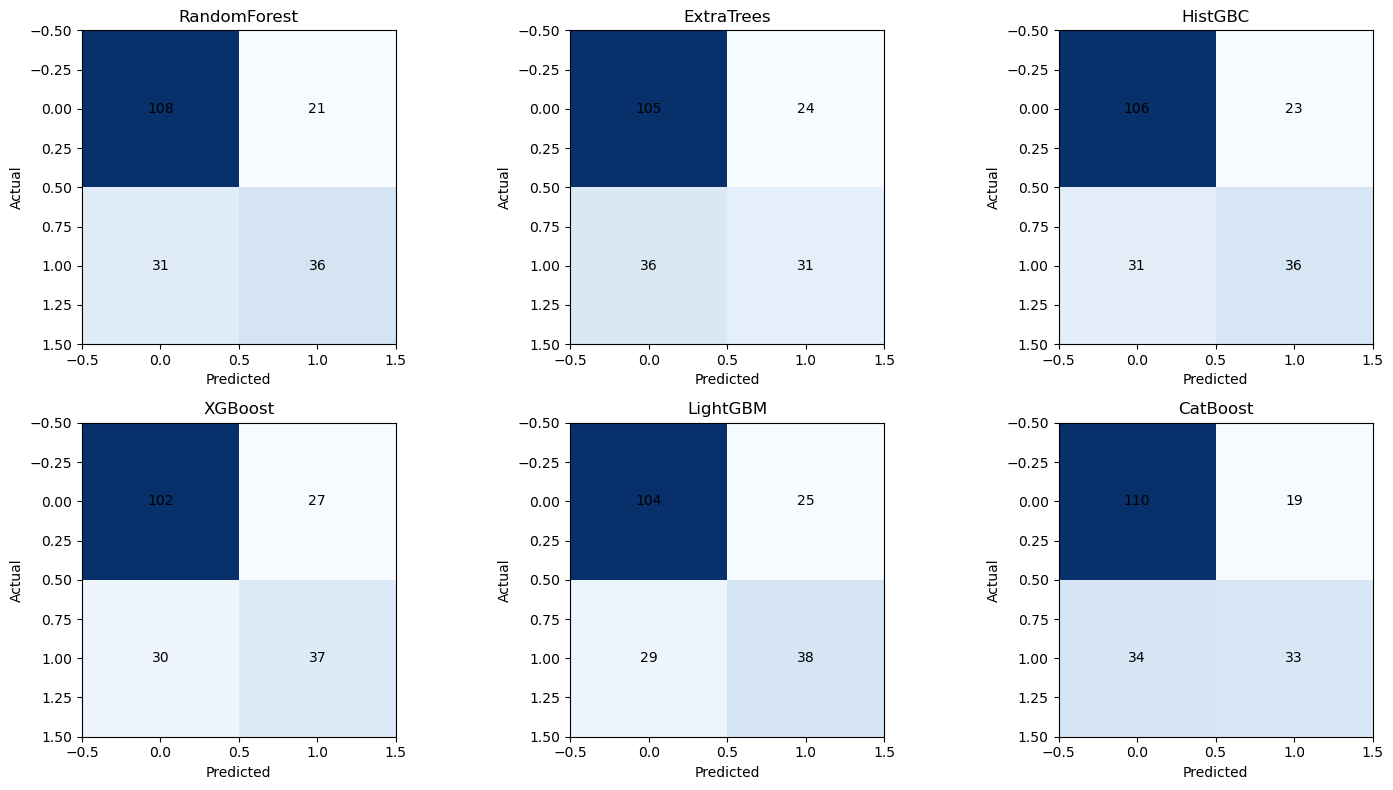

In [16]:
# Визуализация confusion matrix
print("\n Confusion matrices:")

n_models = len(all_conf_matrices)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, (name, cm) in enumerate(all_conf_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Удаляем лишние оси
for i in range(len(all_conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [17]:
# данные
lgb_train = lgb.Dataset(X_train, label=y_train)

# параметры
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": 42,
    "is_unbalance": True,
}

# Optuna × LightGBM
tuner = LightGBMTunerCV(
    params,
    lgb_train,
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    return_cvbooster=True,
    show_progress_bar=False,
)
tuner.run()

# лучшая модель и параметры
cvbooster   = tuner.get_best_booster()
best_iter   = cvbooster.best_iteration
best_params = tuner.best_params

print("Best iteration :", best_iter)
print("Best params    :", best_params)

[I 2025-06-15 17:36:19,317] A new study created in memory with name: no-name-f8051b55-3b3b-467c-8866-2137d4768bfe
[I 2025-06-15 17:36:24,488] Trial 0 finished with value: 0.7118660775938453 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.7118660775938453.
[I 2025-06-15 17:36:28,794] Trial 1 finished with value: 0.7162269274719366 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.7162269274719366.
[I 2025-06-15 17:36:32,834] Trial 2 finished with value: 0.7175010968731478 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.7175010968731478.
[I 2025-06-15 17:36:37,426] Trial 3 finished with value: 0.7130529248932153 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.7175010968731478.
[I 2025-06-15 17:36:41,398] Trial 4 finished with value: 0.715691066747328 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.7175010968731478.
[I 2025-06-15 17:36:46,970] Trial 5 finished with va

Best iteration : -1
Best params    : {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42, 'is_unbalance': True, 'feature_pre_filter': False, 'lambda_l1': 0.032415724683353374, 'lambda_l2': 1.4402403763589455e-07, 'num_leaves': 31, 'feature_fraction': 0.784, 'bagging_fraction': 0.8347168321162426, 'bagging_freq': 5, 'min_child_samples': 5}


Test Accuracy : 0.6990
Test ROC-AUC  : 0.7151
Метрики на тестовой выборке:


,Accuracy,Precision,Recall,F1-score,ROC AUC
0,0.699,0.562,0.537,0.55,0.715


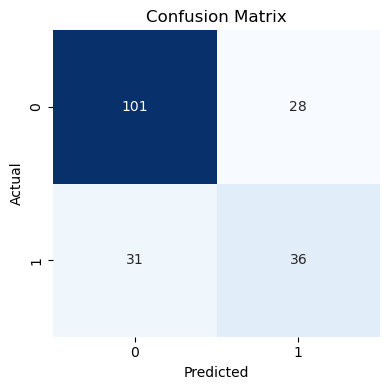

In [18]:
fold_preds = cvbooster.predict(X_test)

y_proba = np.mean(fold_preds, axis=0)
y_pred = (y_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy : {acc:.4f}")
print(f"Test ROC-AUC  : {auc:.4f}")

# Метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

# Таблица метрик
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1-score": [f1],
    "ROC AUC": [roc]
}).round(3)

print("Метрики на тестовой выборке:")
display(metrics_df)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
